<a href="https://colab.research.google.com/github/KyraSebestyen/bioEmbedding/blob/main/mapBertToTokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install flair

     |████████████████████████████████| 322 kB 5.4 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 3.4 MB 48.8 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 981 kB 44.5 MB/s 
     |████████████████████████████████| 788 kB 42.6 MB/s 
     |████████████████████████████████| 1.2 MB 35.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61 kB 479 kB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
     |████████████████████████████████| 596 kB 34.7 MB/s 
     |████████████████████████████████| 3.3 MB 48.5 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=457161b8031fc9972cf0d07d8364334c34544b4a5080f2

In [3]:
import pandas
import numpy
from tqdm.notebook import tqdm
import os
import gzip
import json
import seaborn
import matplotlib.pyplot
import flair
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings
import torch
import spacy

In [4]:
lossData = []

with open('/content/gdrive/My Drive/finetune_neu/checkpoint-17000/trainer_state.json') as file:
  checkpointData = json.load(file)
checkpointData = pandas.DataFrame(checkpointData["log_history"])
lossData.append(checkpointData)

lossData = pandas.concat(lossData)

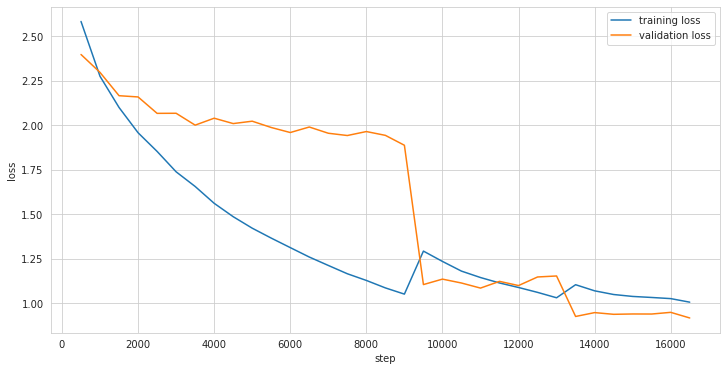

In [5]:
matplotlib.pyplot.figure(figsize = (12, 6))
seaborn.set_style("whitegrid")

seaborn.lineplot(x = "step", y = "loss", data = lossData, label = "training loss")
seaborn.lineplot(x = "step", y = "eval_loss", data = lossData, label = "validation loss")

In [6]:
selectedBert = "/content/gdrive/My Drive/finetune_neu/checkpoint-17000"

In [7]:
corpus = pandas.read_csv('/content/gdrive/My Drive/Colab_Notebooks/Okkurrenzen Auszug.csv', sep = ';', quoting = 3) # 3 means QUOTE_NONE

In [8]:
with pandas.option_context('display.max_rows', 100, 'display.max_columns', 10):
  display(corpus)

,OccId,Term,Scientific Name,File,1000-Words-Frame,text
0,cattle,Bos taurus,organism,PG10005,1,"the travellers visit a gentleman farmer, who i..."
1,plant,Plantae,organism,PG10005,2,i then exhibited some of what i considered my ...
2,bird,Aves,organism,PG10005,2,"i next produced some rare insects, and feather..."
3,insect,Insecta,organism,PG10005,2,"i next produced some rare insects, and feather..."
4,shark,Selachimorpha,organism,PG10005,4,"we had, in singular succession, dead calms and..."
...,...,...,...,...,...,...
20671,tree,Tracheophyta,organism,PG1015,154,"at length, for the first time during about hal..."
20672,horse,Equus ferus caballus,organism,PG1015,154,"westport had beheld strange scenes, but a roug..."
20673,horse,Equus ferus caballus,organism,PG1015,155,here we were soon visited by a number of peopl...
20674,moccasin,Agkistrodon,organism,PG1015,155,in the morning we hardly recognized each other...


In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
nlp.disable_pipes(["parser", "ner"])
# nlp.add_pipe(nlp.create_pipe("sentencizer") , after = "tagger") # not needed because corpus is provided sentence wise

[('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f93152d2fa0>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f93152d9440>)]

In [11]:
def spacy_to_json(spacy_doc):
    doc_dict = spacy_doc.to_json()
    # print(doc_dict)
    sent_boundaries = [10000] # habe nur Sätze und brauche deshalb nicht Satzende
    doc_dict = doc_dict["tokens"]
    current_sentence = 0
    for i, t in enumerate(spacy_doc):
        doc_dict[i]["text"] = t.text
        if spacy_doc[i].is_sent_start:
            doc_dict[i]["is_sent_start"] = True
        else:
            doc_dict[i]["is_sent_start"] = False
        if doc_dict[i]["end"] > sent_boundaries[current_sentence]:
            current_sentence += 1
        doc_dict[i]["sentence_id"] = current_sentence
    return doc_dict


In [12]:
def get_batches(lst, batch_size):
  for i in range(0, len(lst), batch_size): 
    yield lst[i : i + batch_size] # gibt stückweise Elemente der Liste (1 Batch pro Iteration)

In [13]:
def get_sentences(doc):
  current_sentence = 0
  sentence = []
  for t in doc:
    if t["sentence_id"] == current_sentence:
      sentence.append(t["text"])
    else:
      yield sentence 
      sentence = [t["text"]]
      current_sentence = t["sentence_id"]
    if len(sentence) > 0:
      yield sentence

In [14]:
def get_sentence_token_mapping(doc):
  sentence_token_mapping = {}

  current_sentence = 0
  token_id_in_sent = 0
  for i, t in enumerate(doc):
    if t["sentence_id"] != current_sentence:
      current_sentence = t["sentence_id"]
      token_id_in_sent = 0
    sentence_token_mapping[(current_sentence, token_id_in_sent)] = i
    token_id_in_sent += 1

  return sentence_token_mapping

In [15]:
from datetime import datetime

In [ ]:
# ORDNER EMBEDDING UND ORDNER EMBEDDINGS ANLEGEN !!!!

In [17]:
bert_model = TransformerWordEmbeddings(selectedBert,
                                       subtoken_pooling = "mean",
                                       layers = "all",
                                       layer_mean = True,
                                       allow_long_sentences = True)

out_filename_embeddings = "embedding/embeddings.npy"
out_file_metadata = gzip.open("embeddings/token_metadata.tsv.gz", "wt")

metadata_columns = ["token_id", "token",  "doc_token_id", "sentence_id", "text_position", "pos_penn", "pos_univ"] #lemma

out_file_metadata.write("\t".join(metadata_columns) + "\n")

embeddings = []

running_token_id = 0

for batch_indices in get_batches(corpus.index.to_list(), 5): # holt sich Indizes des Batch
    metadata = []
    print(batch_indices)
    print(datetime.now())
    
    for (occId, file), doc in zip(corpus.loc[batch_indices, ["OccId", "File"]].values, # sucht die Zeilen batch_indices und die Spalten OccId und File
                                                   nlp.pipe(corpus.loc[batch_indices, "text"].values, # sucht die Spalte text und wendet die Pipeline auf jeden Satz an
                                                   batch_size = 10)): # zip macht aus zwei Arrays ein Array von Tupeln
        
        doc = spacy_to_json(doc)
       # sent_tokens_map = get_sentence_token_mapping(doc)

        sentences = []
        for s in get_sentences(doc):
            sentences.append(Sentence(s))

        bert_model.embed(sentences)
            
        for sentenceIndex, sentence in enumerate(sentences):
            for tokenIndex, sentenceToken in enumerate(sentence):
                
               # token_id = sent_tokens_map[(sentenceIndex, tokenIndex)]
                tokenFromMap = doc[tokenIndex]
                    
               # lemma = tokenFromMap["lemma"] #lemma ist nicht im Token ???
                text = tokenFromMap["text"]
                
                # Filter out None-entries
                if type(text) != str: #or type(lemma) != str:
                    continue
                    
                # uns interessiet nur das Embedding vom Bio-Begriff
                if text != occId:
                    continue

                # Check if Flair Sentence and document tokens are aligned
                if str(text.lower().strip()) != str(sentenceToken.text.lower().strip()):
                    print("Token is not identical!", text, sentenceToken.text)
                    
                metadata.append({
                    "token_id" : running_token_id,
                    "token" : text,
                    #"lemma" : lemma,
                    "doc_token_id" : tokenIndex,
                    "sentence_id" : tokenFromMap["sentence_id"],
                    "text_position" : (tokenFromMap["start"], tokenFromMap["end"]),
                    "pos_penn" : tokenFromMap["tag"],
                    "pos_univ" : tokenFromMap["pos"],
                })
                
                embeddings.append(sentence[tokenIndex].embedding.detach().cpu().numpy())
                running_token_id += 1
    
    # Ensure embeddings can be mapped to running token index       
    assert len(embeddings) == running_token_id
    
    # Write metadata
    for entry in metadata:
        out_file_metadata.write("\t".join([str(entry[column]) for column in metadata_columns]) + "\n")
    
    # Save embeddings array
    numpy.save(out_filename_embeddings, numpy.vstack(embeddings), allow_pickle = False)
    
out_file_metadata.close()
        


[0, 1, 2, 3, 4]
2022-01-09 17:00:02.237032
[5, 6, 7, 8, 9]
2022-01-09 17:00:13.512147
[10, 11, 12, 13, 14]
2022-01-09 17:00:19.988639
[15, 16, 17, 18, 19]
2022-01-09 17:00:28.013622
[20, 21, 22, 23, 24]
2022-01-09 17:00:33.704001
[25, 26, 27, 28, 29]
2022-01-09 17:00:45.440031
[30, 31, 32, 33, 34]
2022-01-09 17:00:48.297321
[35, 36, 37, 38, 39]
2022-01-09 17:01:11.644556
[40, 41, 42, 43, 44]
2022-01-09 17:01:26.262075
[45, 46, 47, 48, 49]
2022-01-09 17:01:37.092425
[50, 51, 52, 53, 54]
2022-01-09 17:01:43.504425
[55, 56, 57, 58, 59]
2022-01-09 17:01:52.158299
[60, 61, 62, 63, 64]
2022-01-09 17:02:02.903977
[65, 66, 67, 68, 69]
2022-01-09 17:02:13.241681
[70, 71, 72, 73, 74]
2022-01-09 17:02:31.433145
[75, 76, 77, 78, 79]
2022-01-09 17:02:36.819132
[80, 81, 82, 83, 84]
2022-01-09 17:02:45.999575
[85, 86, 87, 88, 89]
2022-01-09 17:02:56.838088
[90, 91, 92, 93, 94]
2022-01-09 17:03:04.839485


RuntimeError: ignored